In [92]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt

In [93]:
print(tf.__version__)

fashion_mnist = tf.keras.datasets.fashion_mnist

# load the training and test data    
(tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

# reshape the feature data
tr_x = tr_x.reshape(tr_x.shape[0], 784)
te_x = te_x.reshape(te_x.shape[0], 784)

# noramlise feature data
tr_x = tr_x / 255.0
te_x = te_x / 255.0
tr_x = tr_x.T
te_x = te_x.T

print( "Shape of training features ", tr_x.shape)
print( "Shape of test features ", te_x.shape)



# one hot encode the training labels and get the transpose
tr_y = np_utils.to_categorical(tr_y,10)
tr_y = tr_y.T
print ("Shape of training labels ", tr_y.shape)

# one hot encode the test labels and get the transpose
te_y = np_utils.to_categorical(te_y,10)
te_y = te_y.T
print ("Shape of testing labels ", te_y.shape)

2.1.0
Shape of training features  (784, 60000)
Shape of test features  (784, 10000)
Shape of training labels  (10, 60000)
Shape of testing labels  (10, 10000)


In [94]:
# By Defaultm the matrix has double variables. But the tensorFlow.MatMul to multiple matices, 
# we need the data in the matrices to be as TensorFlow float32 format. 
# We we don't case the datatype, we will get error which is given below
# InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:MatMul] name: MatMul/


tr_x = tf.cast(tr_x, tf.float32) 
te_x = tf.cast(te_x, tf.float32)
tr_y = tf.cast(tr_y, tf.float32)
te_y = tf.cast(te_y, tf.float32)

In [95]:
# We need a coefficient for each of the features and a single bias value
# Weight will be divided into approximatly same count of positive and negative weights as mean is kept as 0
# Stddev is 0.05, to majorty of numbers between -0.05 to 0.05, and almost all of the values between -0.15 to 0.15
# The distribution will follow the Gaussian cruve
# Dafault datatype will be float32
# We will make a matrix of 10 (classes) be 784 (features). The shape will be usefull during the matrix multiplication later
w = tf.Variable(tf.random.normal(shape=[784,10], mean=0.0, stddev=0.05))

# A single bias value is good enough, we will keep the value as 0 for now
b = tf.Variable([0.])
   

In [96]:
# x is input data, feature values for all the instances, (training data -  60000 images)
# X has dimension as features by number of instances
# weight matrix w is created erlier,  matrix of shape 784X10
# b is the bais

def forwardPass(x, w, b):
    w_T = tf.transpose(w)
    y_pred = tf.matmul(w_T, x) + b 
    # Pipe the results through the softmax activiation function. 
    # pass the values to the softmax layer, the softmax layer to convert the values to probabilites
    return softmax(y_pred)



In [97]:
# Receive values from a range, converts the range to 0 to 1; sum of all values will be 1
# Returns the probabilites
def softmax(y_pred):
    y_pred_exp = tf.math.exp(y_pred)
    summation = tf.reduce_sum(y_pred_exp, 0, keepdims=True) 
    return y_pred_exp / summation 



In [98]:
def cross_entropy(y_true, y_pred):
    # Any values less than clip_value_min are set to clip_value_min. Any values greater than clip_value_max are set to clip_value_max.
    # if the calue is less than 1e-10, than it will set to 1e-10, and if the value is more than 1.0, it will set to 1.0
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)

    # Following is the formula for calculating the loss, and we will get loss for all the 10 classes
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=0)
    
    # Calculating the loss, by taking the mean of the losses
    return tf.reduce_mean(loss)

In [99]:

def calculate_accuracy(x, y, w, b):
  # ForwardPass will internally class softmax, and we will get 10 probabilies for the image for fall under a class
  y_pred_softmax = forwardPass(x,w, b)
    
  # Round the predictions by the logistical unit to either 1 or 0
  # If the value will be more than 0.5, we will get a one, else we will set to 0
  #predictions = tf.round(y_pred_softmax)
    
  # tf.equal will return a boolean array: True if prediction correct, False otherwise
  # tf.cast converts the resulting boolean array to a numerical array 
  # 1 if True (correct prediction), 0 if False (incorrect prediction)
  predictions_correct = tf.cast(tf.equal(tf.round(y_pred_softmax), y), tf.float32)
      
  # Finally, we just determine the mean value of predictions_correct (Acuracy)
  return tf.reduce_mean(predictions_correct),y_pred_softmax

In [100]:
def trainModel(num_Iterations = 50):
    # Lists using for storing the values per epoch for building the graph 
    trainingLosses= []
    testLosses= []
    trainingAccuracies = []
    testAccuracies = []
    
    # Iterate our training loop
    for i in range(num_Iterations):
      
      # Create an instance of GradientTape to monitor the forward pass
      # and calcualte the gradients for each of the variables m and c
      with tf.GradientTape() as tape:
        y_pred = forwardPass(tr_x,w, b)
        currentLoss = cross_entropy(tr_y, y_pred)
      # Adding the valuses on the gradient tape, the tape will by the Adam optimizer later
      gradients = tape.gradient(currentLoss, [w, b])
        
      # Calculations for training instances, accuracies and losses
      tr_accuracy, y_pred_softmax = calculate_accuracy(tr_x, tr_y, w, b) #Accuracy on training instances
      
      # Calculations for Test instances, accuracies and losses
      te_accuracy, y_pred_softmax = calculate_accuracy(te_x, te_y, w, b)
      te_currentLoss = cross_entropy(te_y, y_pred_softmax)
    
      # Appending and print the information for training instances
      trainingAccuracies.append(tr_accuracy.numpy())
      trainingLosses.append(currentLoss.numpy())
      print ("Iteration ", i, ": train_loss = ",currentLoss.numpy(), "  train_acc: ", tr_accuracy.numpy())
      
      # Appending and print the information for validation instances
      testLosses.append(te_currentLoss.numpy())
      testAccuracies.append(te_accuracy.numpy())
      print ("Iteration ", i, ": test_loss = ",te_currentLoss.numpy(), "  test_acc: ", te_accuracy.numpy())
      print("*"*60)
    
      #Calling Adam optimizer the for updating the weights and trainfing the data
      tf.keras.optimizers.Adam(learning_rate=0.003).apply_gradients(zip(gradients, [w,b])) 
        
    
    plt.style.use("ggplot") 
    plt.figure()
    plt.plot(testLosses, label="Val Loss")
    plt.plot(trainingLosses, label="Train Loss")
    plt.plot(trainingAccuracies, label="Train Acc")
    plt.plot(testAccuracies, label="Val Acc")
    plt.legend()
    plt.show()
    

Iteration  0 : train_loss =  2.4586134   train_acc:  0.89867
Iteration  0 : test_loss =  2.454957   test_acc:  0.8988
************************************************************
Iteration  1 : train_loss =  2.1348352   train_acc:  0.9
Iteration  1 : test_loss =  2.130685   test_acc:  0.89999
************************************************************
Iteration  2 : train_loss =  1.9038943   train_acc:  0.900125
Iteration  2 : test_loss =  1.9007626   test_acc:  0.90019
************************************************************
Iteration  3 : train_loss =  1.7377236   train_acc:  0.90007335
Iteration  3 : test_loss =  1.737575   test_acc:  0.90015
************************************************************
Iteration  4 : train_loss =  1.5869443   train_acc:  0.9039083
Iteration  4 : test_loss =  1.5871294   test_acc:  0.90412
************************************************************
Iteration  5 : train_loss =  1.4825854   train_acc:  0.90663
Iteration  5 : test_loss =  1.485842

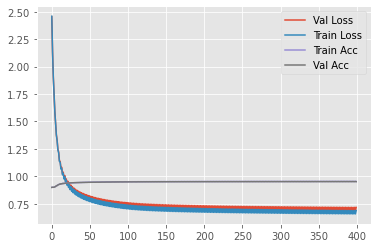

In [101]:
trainModel(400)